In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from skimage.io import imread, imshow, show, imshow_collection
from skimage.transform import resize, rescale, rotate

warnings.filterwarnings('ignore')

# Load Data

In [2]:
data_train_1 = pickle.load(open("data_train_flatten_batch_1.pkl", "rb"))
data_train_2 = pickle.load(open("data_train_flatten_batch_2.pkl", "rb"))
labels_train_1 = pickle.load(open("labels_train_batch_1.pkl", "rb"))
labels_train_2 = pickle.load(open("labels_train_batch_2.pkl", "rb"))

In [3]:
data_train = np.concatenate((data_train_1, data_train_2))
labels_train = np.concatenate((labels_train_1, labels_train_2))

In [4]:
data_test = pickle.load(open("data_test_flatten.pkl", "rb"))
labels_test = pickle.load(open("labels_test.pkl", "rb"))

We don't need to shuffle data because are already splitted in train and test.

# Scale Data

In [5]:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(data_train)
X_test_std = scaler.transform(data_test)

# Train Model

In [6]:
model = LogisticRegression().fit(X_train_std, labels_train)

# Test Model

In [9]:
predictions = model.predict(X_test_std)
accuracy = accuracy_score(labels_test, predictions)
print("Accuracy score:", accuracy)

Accuracy score: 0.3979
[[483  37  53  42  22  29  26  52 183  73]
 [ 56 464  38  45  29  37  37  47  75 172]
 [ 96  36 275 107 121  87 133  75  47  23]
 [ 39  49  98 277  66 191 143  49  32  56]
 [ 55  24 142  76 285  91 170 108  24  25]
 [ 39  44  95 185  96 332  80  65  38  26]
 [ 19  32  81 158  97  94 448  34  13  24]
 [ 51  45  72  73  98  85  35 428  33  80]
 [146  72  29  32  18  37  14  21 531 100]
 [ 64 176  23  35  22  25  49  60  90 456]]


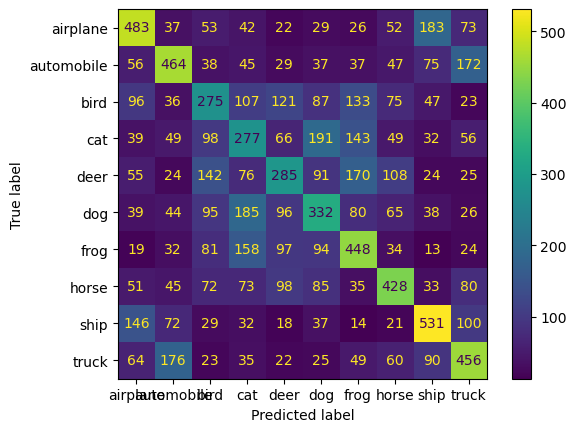

In [14]:
cm = confusion_matrix(labels_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

# Save Model

In [8]:
model_file_name = "logistic_regression_32x32.pkl"
#pickle.dump(model, open(model_file_name, "wb"))